# Boston Housing Linear Regression

### Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D

### Stylistics

In [2]:
%matplotlib inline
plt.style.use("dark_background")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 100)
pd.set_option("precision", 2)

### Import the Dataset

In [3]:
boston_dataset = load_boston()

boston is a bunch data type so we are presented with a dictionary like structure with keys mentioned below.


In [4]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

#### Data Definition

Let's look at the definition of these columns to better understand the data.

In [5]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Based on the Data Definition, we can see that we have 13 columns and the 14th one is the target variable which is the Median Value stored on  bonston_dataset.target.

Both features and target columns are separated so let's join the two columns into one DataFrame for later correlational analysis.

In [6]:
boston = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,0.54,6.58,65.2,4.09,1.0,296.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,0.47,6.42,78.9,4.97,2.0,242.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,0.47,7.18,61.1,4.97,2.0,242.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,0.46,7.00,45.8,6.06,3.0,222.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,0.46,7.15,54.2,6.06,3.0,222.0,18.7,396.90,5.33


In [7]:
boston["MEDV"] = boston_dataset.target

### Data Cleaning

#### Remove NULL Values 

Let's look at if we have null values in our dataset to make sure.

In [8]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Now we are sure that every column in our dataset has no null values.

### Feature Engineering

Let's first check the correlation of each columns in our dataset.

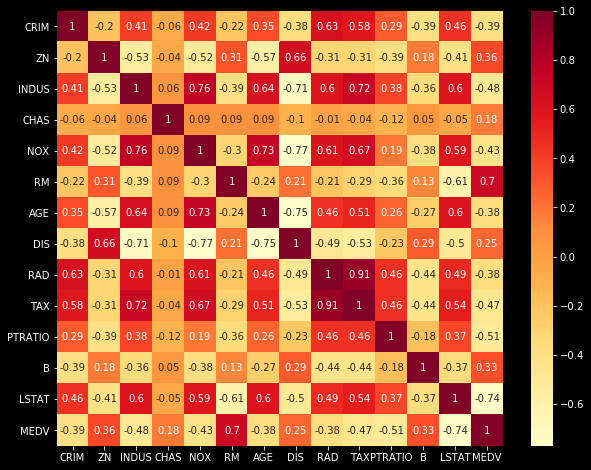

In [9]:
ax, figure = plt.subplots(figsize=(10, 8))
correlation_matrix = boston.corr().round(2)
_ = sns.heatmap(correlation_matrix, annot=True, cmap="YlOrRd")

The higher the intensity of the color is, the more it is correlated to the corresponding column. It means if the value is close to 1, the more they are positively correlated and the closer it is to -1 the more they are negatively correlated.

The goal here is to find the most highly correlated columns into the target feature `MEDV` and use it in linear regression.

Let's all get the features and try to fit all the features into the model and see what the model will take into consideration.

#### Feature Importance

Feature: CRIM, Score: -0.97100
Feature: ZN, Score: 1.04668
Feature: INDUS, Score: -0.04045
Feature: CHAS, Score: 0.59409
Feature: NOX, Score: -1.80877
Feature: RM, Score: 2.60992
Feature: AGE, Score: -0.19823
Feature: DIS, Score: -3.00217
Feature: RAD, Score: 2.08022
Feature: TAX, Score: -1.93289
Feature: PTRATIO, Score: -2.15744
Feature: B, Score: 0.75199
Feature: LSTAT, Score: -3.59027


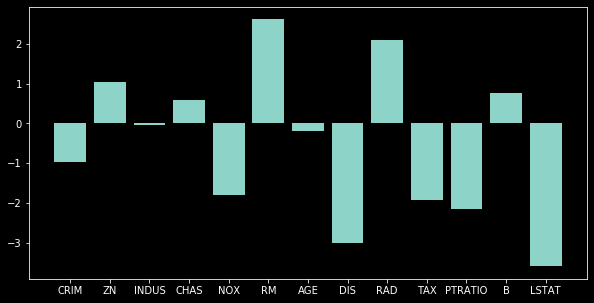

In [10]:
# Split the dataset
X = pd.DataFrame(boston.drop("MEDV", axis=1))
y = boston_dataset.target

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale all the values 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression().fit(X_train, y_train)
importance = regressor.coef_

for idx, val in enumerate(importance):
    col_name = X.iloc[:, idx].name
    print("Feature: {}, Score: {:.5f}".format(col_name, val))

plt.figure(figsize=(10, 5))
_ = plt.bar([X.iloc[:, x].name for x in range(len(importance))], importance)

It seems that features `RM` and `RAD` are the 2 of the most important features here. It makes sense because `RM` pertains to the average rooms per house/apartment and `RAD` pertains to accessibility to urban cities which is the most logical reason for price hikes.

Let's use this in the real action.

### Linear Regression

#### Data Splitting

In [11]:
X = boston[["RM", "LSTAT"]].values.reshape(-1, 2)
Y = boston_dataset.target

x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(3, 9, 30)      # range of RM values
y_pred = np.linspace(1, 38, 30)  # range of LSTAT values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

#### Feature Scaling

In [13]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

#### Model Traning

In [14]:
regressor = LinearRegression().fit(X, Y)

In [15]:
r2 = regressor.score(X, Y)

In [16]:
predicted = regressor.predict(model_viz)

#### Feature Importance

#### Scoring Metrics

In [17]:
# # Train Data
# y_train_pred = regressor.predict(X_train)
# rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
# r2_train = r2_score(y_train, y_train_pred)

# print("# ------------TRAIN DATA---------------- #")
# print(f"RMSE Score: {rmse}")
# print(f"R2 Score: {r2_train}\n")

# y_test_pred = regressor.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
# r2_test = r2_score(y_test, y_test_pred)

# print("# ------------TEST DATA---------------- #")
# print(f"RMSE Score: {rmse}")
# print(f"R2 Score: {r2_test}")

#### Model Visualization

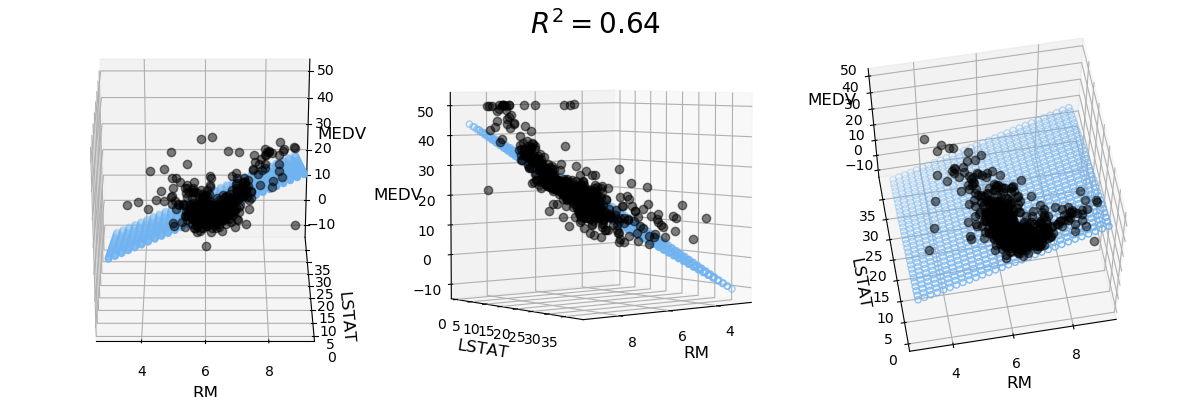

In [52]:
plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color="k", zorder=15, linestyle="none", marker="o", alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor="#70b3f0")
    ax.set_xlabel("RM", fontsize=12)
    ax.set_ylabel("LSTAT", fontsize=12)
    ax.set_zlabel("MEDV", fontsize=12)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")

ax1.view_init(elev=28, azim=-90)
ax2.view_init(elev=4, azim=51)
ax3.view_init(elev=60, azim=-100)

fig.suptitle("$R^2 = %.2f$" % r2, fontsize=20)

fig.tight_layout()

In [53]:
for ii in np.arange(0, 2, 1):
    ax2.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)